# Predicting Insurance Costs

### Introduction

In this guided project, we’ll use **Linear Regression Modeling** to predict medical insurance costs. Accurate predictions can benefit healthcare providers and insurance companies by helping estimate revenues. They can also assist individuals in anticipating potential medical expenses based on personal data.

Our goal is to build a linear regression model that is as accurate as possible. We’ll use a dataset from Kaggle, available [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download), which contains 1,338 records of medical billing information. Each row includes unique attributes for a patient. Throughout the project, we’ll explore how patient characteristics relate to their medical charges.

Let’s begin by importing the necessary libraries and loading our data.

In [1]:
# importing our libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading the data
insurance = pd.read_csv("insurance.csv")
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Exploratory Data Analysis (EDA)

Now that our project is set up, we’ll begin by exploring the dataset and making some initial observations.

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Here are a few things we noticed:

* The dataset contains 1,338 rows and 7 columns.
* There are no null values.
* There are three categorical columns: `sex`, `smoker`, and `region`.
* The `charges` column shows a significant difference between its mean and median values.

We’ll need to keep the categorical variables in mind, as they may require encoding later if we decide to include them in the model. 

### Distribution Normalization

The disparity between the mean and median of the `charges` column suggests potential skewness, which we’ll explore by visualizing its distribution.

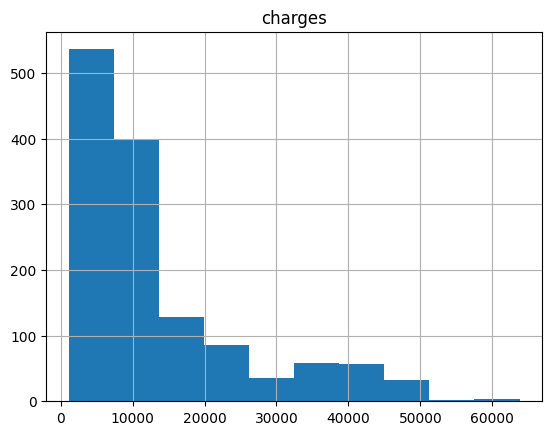

In [5]:
# visualizing the distribution of the charges column
insurance.hist('charges')
plt.show()

The distribution of the `charges` column is heavily **right-skewed**. This indicates that extremely high medical expenses are relatively rare, while most values are clustered at the lower end.

This skewness can impact model accuracy. When we calculate model performance, we typically use error metrics that compare predicted values to actual values. If our target variable is highly skewed, these metrics can become misleading. To address this, we’ll apply a **log transformation** to the `charges` column, creating a new column called `log_charges` to normalize the distribution.

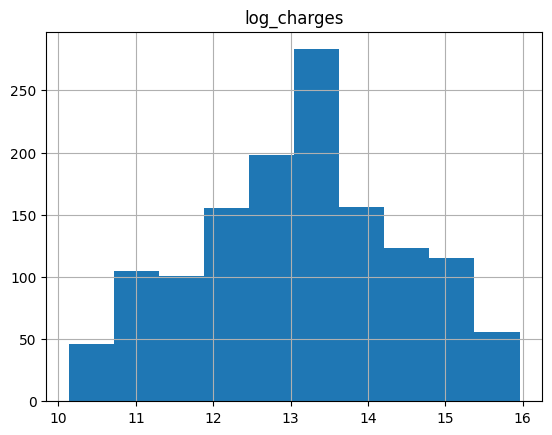

In [6]:
# performing the logarithm function and assigning values to new column
insurance['log_charges'] = np.log2(insurance['charges'])

# visualizing the distribution of our new column
insurance.hist('log_charges')
plt.show()

With the log transformation applied, the distribution becomes more balanced. We can now move forward to examine correlations between the features and our target variable.

### Correlation Analysis

Next, we’ll create a **correlation heatmap** of the numeric variables to identify any strong relationships that could be useful for prediction.

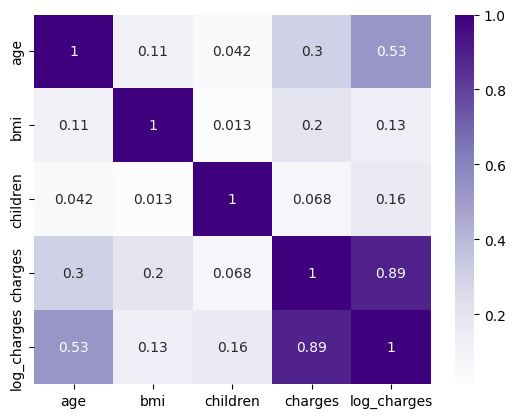

In [7]:
# calculating and visualizing numeric correlations
correlations = insurance.corr(numeric_only=True)
sns.heatmap(correlations, cmap='Purples', annot=True)
plt.show()

Here are a few relationships that stand out:

* **`age`**

  * vs. `log_charges`: 53%
  * vs. `charges`: 30%
* **`children`**

  * vs. `log_charges`: 16%
  * vs. `charges`: 6.8%
* **`bmi`**

  * vs. `log_charges`: 13%
  * vs. `charges`: 20%

Now, let’s examine how the categorical variables relate to the `log_charges` column.

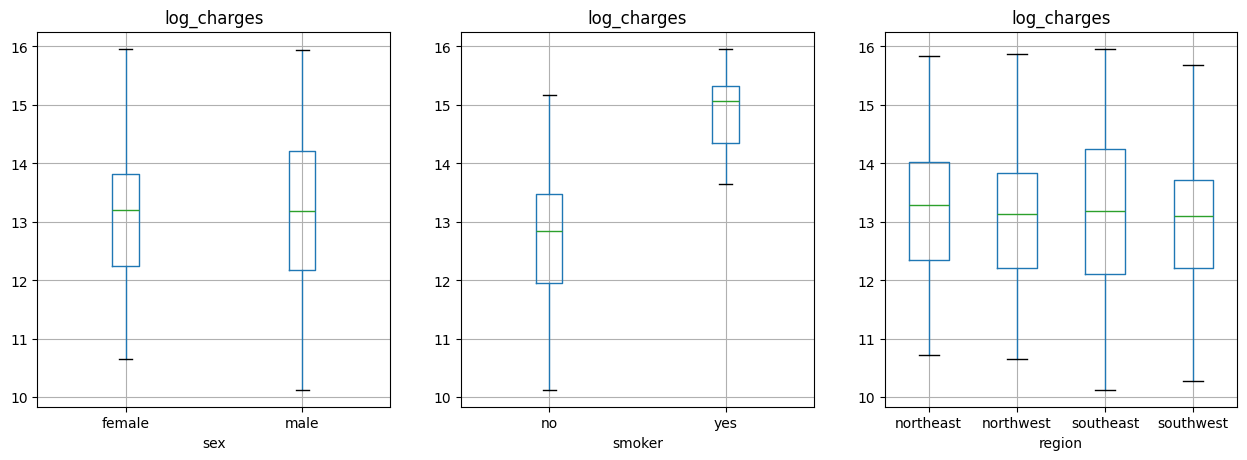

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

insurance.boxplot(column=["log_charges"], by="sex", ax=axs[0])
insurance.boxplot(column=["log_charges"], by="smoker", ax=axs[1])
insurance.boxplot(column=["log_charges"], by="region", ax=axs[2])
plt.suptitle('')

plt.show()

Some key observations:

* Males show a wider range of `log_charges` values than females.
* Smokers incur significantly higher charges compared to non-smokers.
* No particular region shows a dramatic difference in cost distribution.

### Feature Selection

After analyzing the dataset, we’ve selected the most relevant features—both numerical and categorical—for our model:

* `age`
* `children`
* `smoker`

These variables appear to have the strongest relationships with insurance charges.

### Model Preparation

With our features selected, we’re ready to begin constructing our model. In the following code, we’ll:

* Define our independent variables (`age`, `children`, `smoker`)
* Set our dependent variable (`log_charges`)
* Split the dataset into training and testing subsets

In [9]:
# selecting patients who do smoke, for our model feature
insurance['is_smoker'] = (insurance['smoker'] == 'yes')

# defining our dependent and independent variables
X = insurance[['age', 'children', 'is_smoker']]
y = insurance['log_charges']

# splitting our data into training and testing sections for training our model; 75% training data, 25% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)

Now that our variables are defined and our data is split, we can proceed to build the model using the training data. In the next step, we’ll train our model and evaluate its initial performance.

### Model Building

In [10]:
# initiating the model
insurance_model = LinearRegression()

# "fitting" the model; the model learning the relationship between our target variable and the feature variables
insurance_model.fit(X_train, y_train)

LinearRegression()

In [11]:
# the trained model predicting the values of the target variable (log_charges) using the feature columns
y_pred = insurance_model.predict(X_train)

# measuring the average difference between the model's predicted values and the correct values (checking the accuracy)
train_mse = mean_squared_error(y_train, y_pred)
train_mse

0.4291672438545745

In [12]:
# calculating the mean squared error (MSE) as before, but squaring it to see the original scale before the log transformation
train_mse_orig_scale = np.exp2(mean_squared_error(y_train, y_pred))
train_mse_orig_scale

np.float64(1.3464561476287127)

In [13]:
# another function that measures accuracy; the closer the value is to 1, the better the model's predicted values match the actual training data values
train_r2 = r2_score(y_train, y_pred)
train_r2

0.7540788337518134

From our results, we obtained the following metrics using the **training data**:

* **MSE**: 0.429
* **RMSE**: 1.35
* **R²**: 75%

These results are promising! However, since this evaluation is based on training data (the data the model learned from), it’s expected that performance is high. When we evaluate the model on new, unseen data, accuracy will likely decrease to some extent.

### Visual Accuracy Check

Before evaluating on the test data, let’s **visualize our model’s predictions** on the training set to confirm accuracy trends.

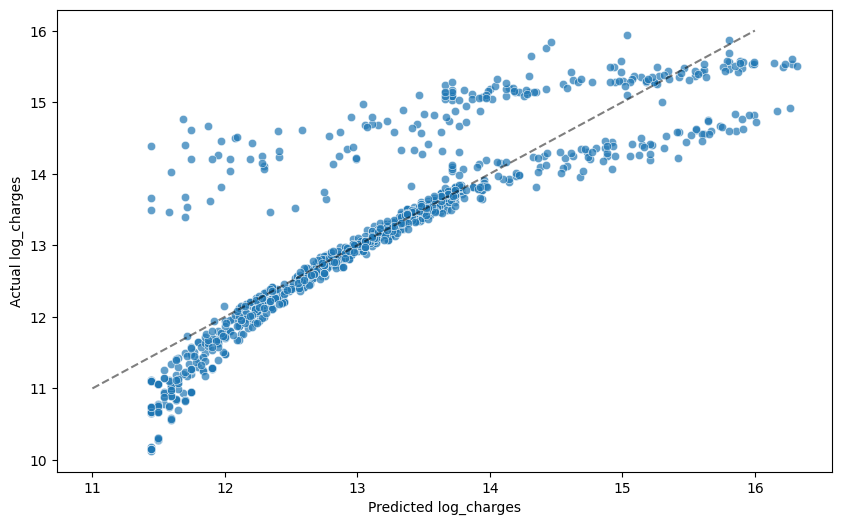

In [14]:
# putting all our model information in one place, to ease accessibility
plot_df = pd.DataFrame({
    'predictions': y_pred,
    'actual': y_train,
    'is_smoker': X_train['is_smoker'],
    'age': X_train['age'],
    'children': X_train['children'],
    'residuals': y_train - y_pred,
})

# plotting the actual values vs. our model's predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='predictions', y='actual', 
                data=plot_df, alpha=0.7)
# reference line (100% model accuracy)
plt.plot([11, 16], [11, 16], 'k--', alpha=0.5)


plt.xlabel('Predicted log_charges')
plt.ylabel('Actual log_charges')

plt.show()

The graph above shows encouraging results. While not all points lie directly on the ideal reference line (which would indicate perfect accuracy), most predictions closely follow the trend, indicating a reletivly strong model fit.

We’ll now generate one more visualization to examine residuals and gain further insight into the model’s performance.

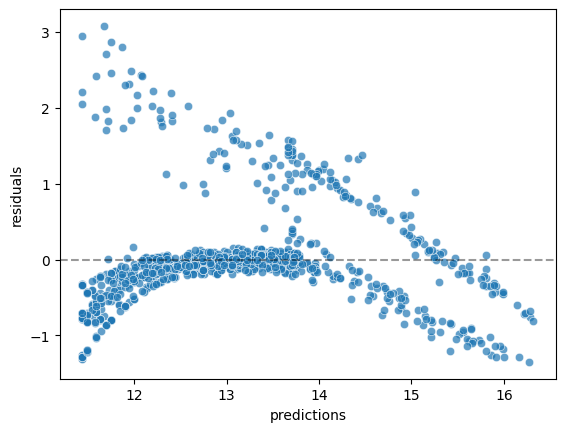

In [15]:
# Visualizing the prediction values in comparison to the ammount of error they had (residuals)
sns.scatterplot(x='predictions', y='residuals', 
                data=plot_df, alpha=0.7)

# reference line; where residual (amount of error) is 0
plt.axhline(y=0, color='k', linestyle='--', alpha=0.4)

plt.show()

In this graph, we plotted **predicted values vs. residuals**. The residual represents the difference between the actual value and the predicted value. A residual of 0 indicates a perfect prediction.

The dashed line at 0 serves as a reference. As we can see, the majority of residuals are fairly evenly distributed around this line, reinforcing the idea that our model’s predictions are consistently close to the actual values. With this confirmation, let’s move on to interpret the mathematics of the model.

### Model Interpretation

To gain deeper insight, we’ll now examine the model’s **intercept**. The intercept represents the target value when all independent variables are set to 0.

In [16]:
insurance_model.intercept_

np.float64(10.523671751479178)

From our output, the **intercept** is `10.5`.

But what does this mean? Let's recall that our features are `age`, `children`, and `smoker`. A scenario where all these are 0 is not realistic—no person has an age of 0, and someone cannot simultaneously be a smoker and a non-smoker, even if they have 0 children.

So, while the intercept lacks practical meaning on its own, it can still serve as a **baseline reference** for model predictions. It might also be useful for hospital administrators as a starting point for estimating revenue or pricing benchmarks.

Next, let’s look at the **regression coefficients**. These tell us how much the predicted outcome changes with a one-unit change in each feature. Mathematically, our model follows this structure:

$$y = b_0 + b_1x_1 + b_2x_2 + b_3x_3 + \epsilon$$

Each variable in the equation represents:

* **y** = Target variable (`log_charges`)
* **b₀** = Intercept (`10.5`)
* **b₁, b₂, b₃** = Coefficients for the independent variables
* **x₁, x₂, x₃** = Independent variables (`age`, `children`, and `smoker`)
* **ε** = Error term (unexplained variation)

The coefficient for each predictor indicates how much `log_charges` is expected to change with a one-unit increase in that feature.

We used built-in functions to calculate these coefficients and created a small dataframe for clarity.

In [17]:
coef_df = pd.DataFrame(insurance_model.coef_, X.columns, columns=['Coef'])
print(coef_df)

               Coef
age        0.050944
children   0.137931
is_smoker  2.221429


Above, we can see the calculated coefficients. Now that we have all our values, we can enter them into our model formula:

$$log\_charges = 10.5 + 0.05 \times age + 0.138 \times children + 2.221 \times is\_smoker + \epsilon$$

### Coefficient Interpretations

**Age**

* Coefficient: 0.05
* Interpretation: For each additional year in age, `log_charges` increases by 0.05.

**Children**

* Coefficient: 0.138
* Interpretation: For each additional child, `log_charges` increases by 0.138.

**Is Smoker**

* Coefficient: 2.221
* Interpretation: Being a smoker increases `log_charges` by 2.221.

These coefficients provide meaningful insight into how each feature contributes to insurance costs. For hospital and insurance administrators, this information helps identify key risk factors and improve revenue forecasting and business planning.

### Final Model Evaluation

Having trained and interpreted our model, we’re ready to evaluate it using **unseen test data**. We’ll calculate the **Mean Squared Error (MSE)** to assess its performance. Ideally, the test MSE should be close to the training MSE, which would indicate that our model generalizes well and hasn’t been overfitted.

In [18]:
# having our model predict the charges values for the test data (new unseen data)
test_pred = insurance_model.predict(X_test)

# calculating the MSE for the model on our test data
mean_squared_error(y_test, test_pred)

0.42041795869004406

Remember, our model is trained on **log-transformed charges**. Let's also check the MSE on the original (non-transformed) scale to get a complete picture.

In [19]:
# original scale MSE
np.exp2(mean_squared_error(y_test, test_pred))

np.float64(1.3383152177654423)

We find that the **test MSE on the log scale** is 0.420, which is very close to the **training MSE** of 0.429. This small difference suggests our model generalizes well and performs reliably on new data.

As a final step, let’s compute the **R² score** on the test data to determine how much variance is explained by the model.

In [20]:
accuracy = r2_score(y_test, test_pred)
print(f'''{accuracy*100:.2f}%''')

76.62%


### Conclusion

In this guided project, we demonstrated how to use **Linear Regression Modeling** to build a predictive model for medical insurance charges. With a final accuracy of **76.62%**, our model proves to be both effective and informative.

Much of this success can be attributed to our choice of predictive features and the use of a log transformation on the target variable. This project only scratches the surface of what linear regression—and machine learning in general—can accomplish. With further refinement, this model could be extended in various ways for even more robust predictions.

We hope this walkthrough showcased the power and practicality of linear regression modeling in real-world applications.